In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperatures
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperatures
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperatures
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 3
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 3
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

3
179
(84, 1972)
(11, 1972)


[I 2025-05-20 23:33:36,800] A new study created in memory with name: no-name-094bde47-6ccf-4321-9fc4-079d4fb3e6ee
[I 2025-05-20 23:37:40,019] Trial 0 finished with value: 0.07455938458442687 and parameters: {'lr': 0.04128310770403522, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.16387783634175518}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.053395792841911316, 0.05268658697605133, 0.09088453650474548, 0.09742747992277145, 0.07840252667665482]
Mean Cross Validation Accuracy:
0.07455938458442687
Standard Deviation of Cross Validation Accuracy:
0.01860401570321303


[I 2025-05-20 23:43:59,615] Trial 1 finished with value: 0.08175358548760414 and parameters: {'lr': 0.016747786605561442, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.44556334342681136}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.06236429512500763, 0.06155485287308693, 0.09357121586799622, 0.10705740749835968, 0.08422015607357025]
Mean Cross Validation Accuracy:
0.08175358548760414
Standard Deviation of Cross Validation Accuracy:
0.01771980330936523


[I 2025-05-20 23:48:14,006] Trial 2 finished with value: 1.4537458419799805 and parameters: {'lr': 0.021689783404361566, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.15656085872980785}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[1.3598443269729614, 1.4955010414123535, 1.470582127571106, 1.457152247428894, 1.4856494665145874]
Mean Cross Validation Accuracy:
1.4537458419799805
Standard Deviation of Cross Validation Accuracy:
0.04873170747938999


[I 2025-05-20 23:53:31,337] Trial 3 finished with value: 0.10677383840084076 and parameters: {'lr': 0.16130719511966493, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.47964329502980596}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.10844690352678299, 0.1045803502202034, 0.09321116656064987, 0.11796212941408157, 0.10966864228248596]
Mean Cross Validation Accuracy:
0.10677383840084076
Standard Deviation of Cross Validation Accuracy:
0.008063675961608329


[I 2025-05-21 00:00:50,378] Trial 4 finished with value: 0.10325824171304702 and parameters: {'lr': 0.10310873782614284, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.29018531005702913}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.09718645364046097, 0.1080402061343193, 0.0944259911775589, 0.11498977988958359, 0.10164877772331238]
Mean Cross Validation Accuracy:
0.10325824171304702
Standard Deviation of Cross Validation Accuracy:
0.007456028513466535


[I 2025-05-21 00:08:21,831] Trial 5 finished with value: 10.150884342193603 and parameters: {'lr': 0.9941119018937289, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2974515663151207}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[7.493751525878906, 5.374560832977295, 13.6780366897583, 18.162240982055664, 6.045831680297852]
Mean Cross Validation Accuracy:
10.150884342193603
Standard Deviation of Cross Validation Accuracy:
4.966844417115546


[I 2025-05-21 00:18:12,986] Trial 6 finished with value: 0.7805642247200012 and parameters: {'lr': 0.012585726284061008, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.42302828364373923}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.8262413144111633, 0.8323204517364502, 0.8086719512939453, 0.6495278477668762, 0.786059558391571]
Mean Cross Validation Accuracy:
0.7805642247200012
Standard Deviation of Cross Validation Accuracy:
0.06746240231114162


[I 2025-05-21 00:28:27,093] Trial 7 finished with value: 2.3011019468307494 and parameters: {'lr': 0.799719430831762, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21964635783696373}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[1.3865159749984741, 2.4007444381713867, 2.780951738357544, 2.3208603858947754, 2.6164371967315674]
Mean Cross Validation Accuracy:
2.3011019468307494
Standard Deviation of Cross Validation Accuracy:
0.4850729149572305


[I 2025-05-21 00:38:00,886] Trial 8 finished with value: 0.08607270270586014 and parameters: {'lr': 0.011403747689312219, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21258148130693058}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.0614219568669796, 0.05749380216002464, 0.1028376892209053, 0.11291578412055969, 0.09569428116083145]
Mean Cross Validation Accuracy:
0.08607270270586014
Standard Deviation of Cross Validation Accuracy:
0.022443722469647702


[I 2025-05-21 00:45:21,479] Trial 9 finished with value: 0.7922906994819641 and parameters: {'lr': 0.0332310495008627, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.20563478393357626}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.8669515252113342, 0.8779414892196655, 0.7966859340667725, 0.6962361931800842, 0.7236383557319641]
Mean Cross Validation Accuracy:
0.7922906994819641
Standard Deviation of Cross Validation Accuracy:
0.07330651710674141


[I 2025-05-21 00:52:30,228] Trial 10 finished with value: 0.1563292309641838 and parameters: {'lr': 0.0016828550882276795, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1100848298895854}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.2862941026687622, 0.10945820808410645, 0.14332804083824158, 0.12783974409103394, 0.11472605913877487]
Mean Cross Validation Accuracy:
0.1563292309641838
Standard Deviation of Cross Validation Accuracy:
0.06602918502591568


[I 2025-05-21 01:01:50,271] Trial 11 finished with value: 0.08148668184876443 and parameters: {'lr': 0.0028776554195639086, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3828256259066911}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.06345286220312119, 0.05942773446440697, 0.08949293941259384, 0.10337340831756592, 0.09168646484613419]
Mean Cross Validation Accuracy:
0.08148668184876443
Standard Deviation of Cross Validation Accuracy:
0.01708203933732377


[I 2025-05-21 01:11:26,566] Trial 12 finished with value: 0.24470362067222595 and parameters: {'lr': 0.001372765410104018, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.38341968211057}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.16177648305892944, 0.2695162296295166, 0.3471207618713379, 0.27872520685195923, 0.1663794219493866]
Mean Cross Validation Accuracy:
0.24470362067222595
Standard Deviation of Cross Validation Accuracy:
0.07109710958845053


[I 2025-05-21 01:17:37,600] Trial 13 finished with value: 0.08095696046948433 and parameters: {'lr': 0.004405420330092713, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.36592845580058364}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.06210066378116608, 0.05562857165932655, 0.09085206687450409, 0.10945078730583191, 0.08675271272659302]
Mean Cross Validation Accuracy:
0.08095696046948433
Standard Deviation of Cross Validation Accuracy:
0.01970019922380793


[I 2025-05-21 01:23:29,005] Trial 14 finished with value: 0.08248324766755104 and parameters: {'lr': 0.005032447701422432, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3465072654398914}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.06291989982128143, 0.059140805155038834, 0.09954040497541428, 0.11080086976289749, 0.08001425862312317]
Mean Cross Validation Accuracy:
0.08248324766755104
Standard Deviation of Cross Validation Accuracy:
0.020132185399829944


[I 2025-05-21 01:32:14,167] Trial 15 finished with value: 0.08289379924535752 and parameters: {'lr': 0.07914981294623243, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2552277254261301}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.06304944306612015, 0.06256221234798431, 0.09612918645143509, 0.10635066777467728, 0.08637748658657074]
Mean Cross Validation Accuracy:
0.08289379924535752
Standard Deviation of Cross Validation Accuracy:
0.017576735368786758


[I 2025-05-21 01:39:40,054] Trial 16 finished with value: 0.08261979892849922 and parameters: {'lr': 0.005395510544598288, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11808104526077412}. Best is trial 0 with value: 0.07455938458442687.


Cross Validation Accuracies:
[0.06388767063617706, 0.058407727628946304, 0.09531521797180176, 0.10779588669538498, 0.087692491710186]
Mean Cross Validation Accuracy:
0.08261979892849922
Standard Deviation of Cross Validation Accuracy:
0.01875024425954505


[I 2025-05-21 01:47:46,218] Trial 17 finished with value: 0.07401115372776985 and parameters: {'lr': 0.04549948482581961, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3397906522980676}. Best is trial 17 with value: 0.07401115372776985.


Cross Validation Accuracies:
[0.05712999403476715, 0.054028090089559555, 0.08056275546550751, 0.10434649139642715, 0.07398843765258789]
Mean Cross Validation Accuracy:
0.07401115372776985
Standard Deviation of Cross Validation Accuracy:
0.018151876474738798


[I 2025-05-21 01:53:46,027] Trial 18 finished with value: 0.08258730694651603 and parameters: {'lr': 0.3246608684211794, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.32602391962990374}. Best is trial 17 with value: 0.07401115372776985.


Cross Validation Accuracies:
[0.06987806409597397, 0.0573241151869297, 0.0975336804986, 0.10091505199670792, 0.08728562295436859]
Mean Cross Validation Accuracy:
0.08258730694651603
Standard Deviation of Cross Validation Accuracy:
0.01662003734056333


[I 2025-05-21 02:00:34,416] Trial 19 finished with value: 0.06794392690062523 and parameters: {'lr': 0.04609430817437998, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16267774397043058}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.05407463014125824, 0.05093139782547951, 0.07691648602485657, 0.08977597951889038, 0.06802114099264145]
Mean Cross Validation Accuracy:
0.06794392690062523
Standard Deviation of Cross Validation Accuracy:
0.014414817646523298


[I 2025-05-21 02:08:32,710] Trial 20 finished with value: 0.07681903392076492 and parameters: {'lr': 0.052000715313068144, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.269893327083541}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.054984454065561295, 0.0571940653026104, 0.07527346163988113, 0.11364636570215225, 0.08299682289361954]
Mean Cross Validation Accuracy:
0.07681903392076492
Standard Deviation of Cross Validation Accuracy:
0.021254150216471868


[I 2025-05-21 02:16:29,815] Trial 21 finished with value: 0.07373573407530784 and parameters: {'lr': 0.04157251670929035, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1626486349807522}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.05432891473174095, 0.05162235349416733, 0.08001736551523209, 0.09967982023954391, 0.08303021639585495]
Mean Cross Validation Accuracy:
0.07373573407530784
Standard Deviation of Cross Validation Accuracy:
0.01824592085816179


[I 2025-05-21 02:25:29,626] Trial 22 finished with value: 0.091496641933918 and parameters: {'lr': 0.19080025564439526, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15713718452688863}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.06461001932621002, 0.06259223073720932, 0.10242447257041931, 0.13763736188411713, 0.09021912515163422]
Mean Cross Validation Accuracy:
0.091496641933918
Standard Deviation of Cross Validation Accuracy:
0.0275984457205456


[I 2025-05-21 02:33:26,342] Trial 23 finished with value: 0.09246335923671722 and parameters: {'lr': 0.07102373771801153, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.24127424045427254}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.08073443919420242, 0.0538754016160965, 0.09389320015907288, 0.16282638907432556, 0.07098736613988876]
Mean Cross Validation Accuracy:
0.09246335923671722
Standard Deviation of Cross Validation Accuracy:
0.037525502611373385


[I 2025-05-21 02:40:56,715] Trial 24 finished with value: 0.0754915527999401 and parameters: {'lr': 0.028760452125539446, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3247396543023605}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.055378321558237076, 0.05363257974386215, 0.08901499956846237, 0.10478980094194412, 0.07464206218719482]
Mean Cross Validation Accuracy:
0.0754915527999401
Standard Deviation of Cross Validation Accuracy:
0.0196181006473165


[I 2025-05-21 02:46:58,522] Trial 25 finished with value: 0.09335522577166558 and parameters: {'lr': 0.13882692146347647, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1812450257206734}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.08082414418458939, 0.06097542867064476, 0.09969571232795715, 0.13554647564888, 0.08973436802625656]
Mean Cross Validation Accuracy:
0.09335522577166558
Standard Deviation of Cross Validation Accuracy:
0.024653166988562687


[I 2025-05-21 02:52:34,589] Trial 26 finished with value: 0.08559531047940254 and parameters: {'lr': 0.2881040731537079, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1330874459330902}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.05606628581881523, 0.06418735533952713, 0.13489565253257751, 0.08934792876243591, 0.08347932994365692]
Mean Cross Validation Accuracy:
0.08559531047940254
Standard Deviation of Cross Validation Accuracy:
0.027493079437714337


[I 2025-05-21 02:59:20,602] Trial 27 finished with value: 0.07870009988546371 and parameters: {'lr': 0.055284534091281576, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1895538833464156}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.06206674873828888, 0.07226448506116867, 0.08350381255149841, 0.1018754318356514, 0.07379002124071121]
Mean Cross Validation Accuracy:
0.07870009988546371
Standard Deviation of Cross Validation Accuracy:
0.013434031764357082


[I 2025-05-21 03:06:25,691] Trial 28 finished with value: 0.07931273058056831 and parameters: {'lr': 0.008971345507263896, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.23402998979786863}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.05994671210646629, 0.05460294336080551, 0.09344816952943802, 0.1067080944776535, 0.08185773342847824]
Mean Cross Validation Accuracy:
0.07931273058056831
Standard Deviation of Cross Validation Accuracy:
0.019709946183650653


[I 2025-05-21 03:11:58,277] Trial 29 finished with value: 0.07026986703276634 and parameters: {'lr': 0.0437776838054399, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15803301597430208}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.04927781969308853, 0.05232488736510277, 0.09150660783052444, 0.09072813391685486, 0.06751188635826111]
Mean Cross Validation Accuracy:
0.07026986703276634
Standard Deviation of Cross Validation Accuracy:
0.018109857248453584


[I 2025-05-21 03:20:10,185] Trial 30 finished with value: 0.07656923905014992 and parameters: {'lr': 0.02383331273929528, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.14656750404753233}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.059348538517951965, 0.055590394884347916, 0.09462158381938934, 0.10010591149330139, 0.07317976653575897]
Mean Cross Validation Accuracy:
0.07656923905014992
Standard Deviation of Cross Validation Accuracy:
0.018044473140782752


[I 2025-05-21 03:27:23,792] Trial 31 finished with value: 0.07499555721879006 and parameters: {'lr': 0.04143245322897479, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17410102748033043}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.052343811839818954, 0.0532207265496254, 0.09093943238258362, 0.10416532307863235, 0.07430849224328995]
Mean Cross Validation Accuracy:
0.07499555721879006
Standard Deviation of Cross Validation Accuracy:
0.020458735411660937


[I 2025-05-21 03:33:54,858] Trial 32 finished with value: 0.07177053466439247 and parameters: {'lr': 0.038951181423421855, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10031272379382067}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.051325950771570206, 0.054103001952171326, 0.09100416302680969, 0.08953499794006348, 0.07288455963134766]
Mean Cross Validation Accuracy:
0.07177053466439247
Standard Deviation of Cross Validation Accuracy:
0.01683373036359615


[I 2025-05-21 03:39:32,162] Trial 33 finished with value: 0.07822264432907104 and parameters: {'lr': 0.016637162904569673, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10131855905325302}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.05973006412386894, 0.05335024371743202, 0.09034843742847443, 0.10503589361906052, 0.08264858275651932]
Mean Cross Validation Accuracy:
0.07822264432907104
Standard Deviation of Cross Validation Accuracy:
0.019215545589818243


[I 2025-05-21 03:46:21,057] Trial 34 finished with value: 0.08179328590631485 and parameters: {'lr': 0.08924611690752955, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13354613890014372}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.07804659008979797, 0.08164836466312408, 0.08094336837530136, 0.09091846644878387, 0.07740963995456696]
Mean Cross Validation Accuracy:
0.08179328590631485
Standard Deviation of Cross Validation Accuracy:
0.004842857901708206


[I 2025-05-21 03:54:53,997] Trial 35 finished with value: 0.07815514504909515 and parameters: {'lr': 0.019471371209246194, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15989753595374717}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.058402761816978455, 0.0547054260969162, 0.08951117098331451, 0.1072034165263176, 0.080952949821949]
Mean Cross Validation Accuracy:
0.07815514504909515
Standard Deviation of Cross Validation Accuracy:
0.019599158526144266


[I 2025-05-21 04:02:36,594] Trial 36 finished with value: 0.07746157199144363 and parameters: {'lr': 0.029814025714341268, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12241120791705015}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.060522522777318954, 0.05541953817009926, 0.08965075761079788, 0.09906519204378128, 0.0826498493552208]
Mean Cross Validation Accuracy:
0.07746157199144363
Standard Deviation of Cross Validation Accuracy:
0.016822565266285328


[I 2025-05-21 04:07:48,241] Trial 37 finished with value: 0.07404834777116776 and parameters: {'lr': 0.12088413298061639, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19024365842034166}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.07334567606449127, 0.0721658244729042, 0.07558588683605194, 0.08134834468364716, 0.0677960067987442]
Mean Cross Validation Accuracy:
0.07404834777116776
Standard Deviation of Cross Validation Accuracy:
0.004444848488521712


[I 2025-05-21 04:13:37,796] Trial 38 finished with value: 0.09557471424341202 and parameters: {'lr': 0.06332006042416281, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.14130166370018893}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.0819806456565857, 0.08430735766887665, 0.06606143712997437, 0.1489095240831375, 0.09661460667848587]
Mean Cross Validation Accuracy:
0.09557471424341202
Standard Deviation of Cross Validation Accuracy:
0.028384745437688288


[I 2025-05-21 04:22:14,166] Trial 39 finished with value: 1.268456721305847 and parameters: {'lr': 0.2284480123650613, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1734806994177684}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[1.3459528684616089, 0.42311781644821167, 2.3891732692718506, 0.9788846373558044, 1.2051550149917603]
Mean Cross Validation Accuracy:
1.268456721305847
Standard Deviation of Cross Validation Accuracy:
0.6425680034984896


[I 2025-05-21 04:28:40,857] Trial 40 finished with value: 0.07739929333329201 and parameters: {'lr': 0.032442810094921455, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4947899707594213}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.057140741497278214, 0.05474100261926651, 0.08500377088785172, 0.10657688975334167, 0.08353406190872192]
Mean Cross Validation Accuracy:
0.07739929333329201
Standard Deviation of Cross Validation Accuracy:
0.019342195623956098


[I 2025-05-21 04:34:31,671] Trial 41 finished with value: 0.07572151273488999 and parameters: {'lr': 0.04510825004940396, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4175516899319892}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.08373672515153885, 0.05292346328496933, 0.08278850466012955, 0.08193989843130112, 0.07721897214651108]
Mean Cross Validation Accuracy:
0.07572151273488999
Standard Deviation of Cross Validation Accuracy:
0.011617639769206257


[I 2025-05-21 04:41:45,788] Trial 42 finished with value: 0.09981455355882644 and parameters: {'lr': 0.015651127337587143, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.27931512655041735}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.08535480499267578, 0.06999586522579193, 0.11213986575603485, 0.13949306309223175, 0.09208916872739792]
Mean Cross Validation Accuracy:
0.09981455355882644
Standard Deviation of Cross Validation Accuracy:
0.02401756654136218


[I 2025-05-21 04:49:20,361] Trial 43 finished with value: 0.09268713444471359 and parameters: {'lr': 0.10282859381351579, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10042203184342835}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.09118497371673584, 0.04958470165729523, 0.11889535933732986, 0.13452965021133423, 0.0692409873008728]
Mean Cross Validation Accuracy:
0.09268713444471359
Standard Deviation of Cross Validation Accuracy:
0.031136683165164134


[I 2025-05-21 04:56:40,720] Trial 44 finished with value: 0.08651575222611427 and parameters: {'lr': 0.04012071601355768, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1999134392961968}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.061716485768556595, 0.06503722071647644, 0.10360792279243469, 0.10107486695051193, 0.1011422649025917]
Mean Cross Validation Accuracy:
0.08651575222611427
Standard Deviation of Cross Validation Accuracy:
0.018944001277158784


[I 2025-05-21 05:04:03,005] Trial 45 finished with value: 0.07667000591754913 and parameters: {'lr': 0.011398258261387904, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3113141688879542}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.05685272440314293, 0.05731793865561485, 0.08920948952436447, 0.1040545180439949, 0.07591535896062851]
Mean Cross Validation Accuracy:
0.07667000591754913
Standard Deviation of Cross Validation Accuracy:
0.01830271454998023


[I 2025-05-21 05:10:16,062] Trial 46 finished with value: 0.07991879060864449 and parameters: {'lr': 0.024667300402540927, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2232069091996205}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.06252086907625198, 0.055082570761442184, 0.0916668251156807, 0.10450189560651779, 0.08582179248332977]
Mean Cross Validation Accuracy:
0.07991879060864449
Standard Deviation of Cross Validation Accuracy:
0.018421271873534505


[I 2025-05-21 05:16:57,483] Trial 47 finished with value: 0.1574605345726013 and parameters: {'lr': 0.06663081606214746, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4488286870729747}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.13382574915885925, 0.14867003262043, 0.19366015493869781, 0.15390262007713318, 0.15724411606788635]
Mean Cross Validation Accuracy:
0.1574605345726013
Standard Deviation of Cross Validation Accuracy:
0.0197939087261739


[I 2025-05-21 05:23:21,304] Trial 48 finished with value: 0.08839108645915986 and parameters: {'lr': 0.007768341328408129, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1502533175752715}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.06582088768482208, 0.06552661955356598, 0.11389616131782532, 0.10470186918973923, 0.09200989454984665]
Mean Cross Validation Accuracy:
0.08839108645915986
Standard Deviation of Cross Validation Accuracy:
0.01980830113067565


[I 2025-05-21 05:31:19,897] Trial 49 finished with value: 0.10554209798574447 and parameters: {'lr': 0.5596171996565725, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.12849627783626622}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.08368946611881256, 0.0962132140994072, 0.16972412168979645, 0.0931733176112175, 0.08491037040948868]
Mean Cross Validation Accuracy:
0.10554209798574447
Standard Deviation of Cross Validation Accuracy:
0.03244241874940282


[I 2025-05-21 05:39:29,025] Trial 50 finished with value: 0.08065590932965279 and parameters: {'lr': 0.03924416508251358, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.34876266749483553}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.059970416128635406, 0.05467959865927696, 0.0969216525554657, 0.10950097441673279, 0.08220690488815308]
Mean Cross Validation Accuracy:
0.08065590932965279
Standard Deviation of Cross Validation Accuracy:
0.020984166005832423


[I 2025-05-21 05:46:11,688] Trial 51 finished with value: 0.09863281548023224 and parameters: {'lr': 0.1306312014809728, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.18795849668272707}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.08137097954750061, 0.09623107314109802, 0.06939084827899933, 0.14832308888435364, 0.0978480875492096]
Mean Cross Validation Accuracy:
0.09863281548023224
Standard Deviation of Cross Validation Accuracy:
0.026939083357576134


[I 2025-05-21 05:52:18,087] Trial 52 finished with value: 0.08186136335134506 and parameters: {'lr': 0.12258036698779189, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20395684087330773}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.07226061075925827, 0.08131898939609528, 0.07780621945858002, 0.11116454750299454, 0.06675644963979721]
Mean Cross Validation Accuracy:
0.08186136335134506
Standard Deviation of Cross Validation Accuracy:
0.015464461396968285


[I 2025-05-21 05:57:58,263] Trial 53 finished with value: 0.09818152636289597 and parameters: {'lr': 0.08758317229482071, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1641937239097956}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.09089566767215729, 0.06892205774784088, 0.11933249980211258, 0.10242248326539993, 0.10933492332696915]
Mean Cross Validation Accuracy:
0.09818152636289597
Standard Deviation of Cross Validation Accuracy:
0.017314432691892305


[I 2025-05-21 06:04:24,192] Trial 54 finished with value: 0.07382725700736045 and parameters: {'lr': 0.05066483890262665, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11201381040792782}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.0831381157040596, 0.08337143063545227, 0.06534093618392944, 0.07604954391717911, 0.06123625859618187]
Mean Cross Validation Accuracy:
0.07382725700736045
Standard Deviation of Cross Validation Accuracy:
0.009091455121498573


[I 2025-05-21 06:11:49,069] Trial 55 finished with value: 0.09406511038541794 and parameters: {'lr': 0.05181026937656865, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11322896946296689}. Best is trial 19 with value: 0.06794392690062523.


Cross Validation Accuracies:
[0.06571074575185776, 0.086087167263031, 0.11658889800310135, 0.14124974608421326, 0.06068899482488632]
Mean Cross Validation Accuracy:
0.09406511038541794
Standard Deviation of Cross Validation Accuracy:
0.030709260866459902


[I 2025-05-21 06:19:00,101] Trial 56 finished with value: 0.06635642349720001 and parameters: {'lr': 0.022342556157051968, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11621772651945883}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[0.045555975288152695, 0.05675232782959938, 0.07347109168767929, 0.08828852325677872, 0.06771419942378998]
Mean Cross Validation Accuracy:
0.06635642349720001
Standard Deviation of Cross Validation Accuracy:
0.014549064286621612


[I 2025-05-21 06:25:27,210] Trial 57 finished with value: 0.07154493406414986 and parameters: {'lr': 0.020021317137984374, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11558180138403952}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[0.050746239721775055, 0.05752385035157204, 0.0777602419257164, 0.10097506642341614, 0.07071927189826965]
Mean Cross Validation Accuracy:
0.07154493406414986
Standard Deviation of Cross Validation Accuracy:
0.017519251898028054


[I 2025-05-21 06:31:11,240] Trial 58 finished with value: 0.1241436168551445 and parameters: {'lr': 0.013167776919072496, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14267465832407422}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[0.14257235825061798, 0.08556737750768661, 0.12508127093315125, 0.18253420293331146, 0.0849628746509552]
Mean Cross Validation Accuracy:
0.1241436168551445
Standard Deviation of Cross Validation Accuracy:
0.03680547526933069


[I 2025-05-21 06:37:25,882] Trial 59 finished with value: 1.32786123752594 and parameters: {'lr': 0.02027655626631197, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13006583142372505}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[1.3509047031402588, 1.3725825548171997, 1.274619460105896, 1.3650981187820435, 1.2761013507843018]
Mean Cross Validation Accuracy:
1.32786123752594
Standard Deviation of Cross Validation Accuracy:
0.04343122285134898


[I 2025-05-21 06:44:56,583] Trial 60 finished with value: 0.06998641714453697 and parameters: {'lr': 0.02763333106243708, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.16664575472435858}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[0.041437968611717224, 0.05065159872174263, 0.06677108258008957, 0.10441824793815613, 0.08665318787097931]
Mean Cross Validation Accuracy:
0.06998641714453697
Standard Deviation of Cross Validation Accuracy:
0.023076046939122963


[I 2025-05-21 06:53:47,225] Trial 61 finished with value: 0.06703440770506859 and parameters: {'lr': 0.025586108880042112, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.15817407027204364}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[0.04686571657657623, 0.054334498941898346, 0.08602394163608551, 0.08701829612255096, 0.06092958524823189]
Mean Cross Validation Accuracy:
0.06703440770506859
Standard Deviation of Cross Validation Accuracy:
0.016524471772849512


[I 2025-05-21 07:02:43,847] Trial 62 finished with value: 0.07651757076382637 and parameters: {'lr': 0.023587510872151066, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.11913412677714875}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[0.05884057283401489, 0.0545198880136013, 0.09346994757652283, 0.10097905993461609, 0.07477838546037674]
Mean Cross Validation Accuracy:
0.07651757076382637
Standard Deviation of Cross Validation Accuracy:
0.018358358313107167


[I 2025-05-21 07:09:55,171] Trial 63 finished with value: 0.06900312528014182 and parameters: {'lr': 0.03310395173666233, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.17072739731887926}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[0.07088012993335724, 0.05806482210755348, 0.07972823828458786, 0.08076205849647522, 0.05558037757873535]
Mean Cross Validation Accuracy:
0.06900312528014182
Standard Deviation of Cross Validation Accuracy:
0.010551211664672334


[I 2025-05-21 07:17:04,781] Trial 64 finished with value: 0.07744868770241738 and parameters: {'lr': 0.009496745952374559, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1666866474975877}. Best is trial 56 with value: 0.06635642349720001.


Cross Validation Accuracies:
[0.05846055969595909, 0.052289508283138275, 0.09171521663665771, 0.10746031254529953, 0.07731784135103226]
Mean Cross Validation Accuracy:
0.07744868770241738
Standard Deviation of Cross Validation Accuracy:
0.020483075494418367


[I 2025-05-21 07:23:54,571] Trial 65 finished with value: 0.06597629711031913 and parameters: {'lr': 0.028103881007917792, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1508504424283171}. Best is trial 65 with value: 0.06597629711031913.


Cross Validation Accuracies:
[0.04568951949477196, 0.06263355165719986, 0.07680920511484146, 0.08586443215608597, 0.05888477712869644]
Mean Cross Validation Accuracy:
0.06597629711031913
Standard Deviation of Cross Validation Accuracy:
0.014042127760919086


[I 2025-05-21 07:32:05,462] Trial 66 finished with value: 0.06738516762852668 and parameters: {'lr': 0.03034396820567338, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2202539204561092}. Best is trial 65 with value: 0.06597629711031913.


Cross Validation Accuracies:
[0.052914608269929886, 0.05601935088634491, 0.07717021554708481, 0.09351318329572678, 0.05730848014354706]
Mean Cross Validation Accuracy:
0.06738516762852668
Standard Deviation of Cross Validation Accuracy:
0.015611142652038062


[I 2025-05-21 07:40:23,706] Trial 67 finished with value: 0.07392355799674988 and parameters: {'lr': 0.014943090978435256, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.21835467805009592}. Best is trial 65 with value: 0.06597629711031913.


Cross Validation Accuracies:
[0.059059832245111465, 0.05401349440217018, 0.08039777725934982, 0.10259435325860977, 0.07355233281850815]
Mean Cross Validation Accuracy:
0.07392355799674988
Standard Deviation of Cross Validation Accuracy:
0.017212837068309193


[I 2025-05-21 07:49:58,219] Trial 68 finished with value: 0.164981609582901 and parameters: {'lr': 0.02683283733391098, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1801021579738703}. Best is trial 65 with value: 0.06597629711031913.


Cross Validation Accuracies:
[0.14696337282657623, 0.15194156765937805, 0.17517392337322235, 0.19345511496067047, 0.1573740690946579]
Mean Cross Validation Accuracy:
0.164981609582901
Standard Deviation of Cross Validation Accuracy:
0.0171300787526077


[I 2025-05-21 08:00:14,030] Trial 69 finished with value: 0.07862065136432647 and parameters: {'lr': 0.006668537583434192, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2396066196603481}. Best is trial 65 with value: 0.06597629711031913.


Cross Validation Accuracies:
[0.05829569324851036, 0.054492440074682236, 0.0936780720949173, 0.10783550143241882, 0.07880154997110367]
Mean Cross Validation Accuracy:
0.07862065136432647
Standard Deviation of Cross Validation Accuracy:
0.020374202366288948


[I 2025-05-21 08:08:17,927] Trial 70 finished with value: 0.0652725376188755 and parameters: {'lr': 0.03359554922995077, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1939815702598625}. Best is trial 70 with value: 0.0652725376188755.


Cross Validation Accuracies:
[0.05069895088672638, 0.047324635088443756, 0.09562566876411438, 0.07221195101737976, 0.06050148233771324]
Mean Cross Validation Accuracy:
0.0652725376188755
Standard Deviation of Cross Validation Accuracy:
0.01747425324649193


[I 2025-05-21 08:15:10,660] Trial 71 finished with value: 0.06815780177712441 and parameters: {'lr': 0.03109687150190534, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2591259873584964}. Best is trial 70 with value: 0.0652725376188755.


Cross Validation Accuracies:
[0.060692474246025085, 0.05006216838955879, 0.06991758942604065, 0.08932678401470184, 0.07078999280929565]
Mean Cross Validation Accuracy:
0.06815780177712441
Standard Deviation of Cross Validation Accuracy:
0.012971770534647603


[I 2025-05-21 08:21:54,095] Trial 72 finished with value: 0.07072710543870926 and parameters: {'lr': 0.03293767358978997, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25650337938281287}. Best is trial 70 with value: 0.0652725376188755.


Cross Validation Accuracies:
[0.053843699395656586, 0.057206906378269196, 0.08694656938314438, 0.09879045933485031, 0.056847892701625824]
Mean Cross Validation Accuracy:
0.07072710543870926
Standard Deviation of Cross Validation Accuracy:
0.018499192258012873


[I 2025-05-21 08:28:37,525] Trial 73 finished with value: 0.07277998477220535 and parameters: {'lr': 0.01903173170935164, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25204097167760103}. Best is trial 70 with value: 0.0652725376188755.


Cross Validation Accuracies:
[0.05348874256014824, 0.04849347099661827, 0.08518882095813751, 0.09904646128416061, 0.07768242806196213]
Mean Cross Validation Accuracy:
0.07277998477220535
Standard Deviation of Cross Validation Accuracy:
0.019130748712518877


[I 2025-05-21 08:35:04,677] Trial 74 finished with value: 0.06300168260931968 and parameters: {'lr': 0.03538923105535606, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19828711467502935}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05695909634232521, 0.05226720869541168, 0.0622183233499527, 0.081431545317173, 0.06213223934173584]
Mean Cross Validation Accuracy:
0.06300168260931968
Standard Deviation of Cross Validation Accuracy:
0.009927448833991007


[I 2025-05-21 08:42:07,790] Trial 75 finished with value: 0.08340131938457489 and parameters: {'lr': 0.06288600055942299, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.22723233885381855}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.07205940783023834, 0.06547487527132034, 0.1047353520989418, 0.10665399581193924, 0.06808296591043472]
Mean Cross Validation Accuracy:
0.08340131938457489
Standard Deviation of Cross Validation Accuracy:
0.0183329006014003


[I 2025-05-21 08:50:17,353] Trial 76 finished with value: 0.0732421763241291 and parameters: {'lr': 0.012046632920267095, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2069754841677364}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.055482473224401474, 0.051190413534641266, 0.08606358617544174, 0.10029737651348114, 0.0731770321726799]
Mean Cross Validation Accuracy:
0.0732421763241291
Standard Deviation of Cross Validation Accuracy:
0.018428586206955946


[I 2025-05-21 08:56:45,824] Trial 77 finished with value: 0.21959338784217836 and parameters: {'lr': 0.03717217147065987, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19858609023103108}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.20131239295005798, 0.2212567776441574, 0.1797151267528534, 0.15202759206295013, 0.3436550498008728]
Mean Cross Validation Accuracy:
0.21959338784217836
Standard Deviation of Cross Validation Accuracy:
0.0661568893987938


[I 2025-05-21 09:01:53,620] Trial 78 finished with value: 0.07497166246175765 and parameters: {'lr': 0.024331672012040166, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2684477142637659}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05150942504405975, 0.04929657280445099, 0.10108372569084167, 0.09488973021507263, 0.07807885855436325]
Mean Cross Validation Accuracy:
0.07497166246175765
Standard Deviation of Cross Validation Accuracy:
0.02143786719904007


[I 2025-05-21 09:07:18,329] Trial 79 finished with value: 0.07217768803238869 and parameters: {'lr': 0.017405229334444407, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.21415648509343166}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05576251447200775, 0.04900960996747017, 0.07879866659641266, 0.10025062412023544, 0.07706702500581741]
Mean Cross Validation Accuracy:
0.07217768803238869
Standard Deviation of Cross Validation Accuracy:
0.018232117145394383


[I 2025-05-21 09:14:24,760] Trial 80 finished with value: 0.9427817702293396 and parameters: {'lr': 0.014287032887802711, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.15345524632470237}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.9101800322532654, 0.9476680159568787, 0.9569811224937439, 0.9613475203514099, 0.9377321600914001]
Mean Cross Validation Accuracy:
0.9427817702293396
Standard Deviation of Cross Validation Accuracy:
0.018212940241704365


[I 2025-05-21 09:19:42,135] Trial 81 finished with value: 0.06618563458323479 and parameters: {'lr': 0.03336306360186452, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1913719716646231}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05197853222489357, 0.04105177894234657, 0.07895942032337189, 0.09874597191810608, 0.060192469507455826]
Mean Cross Validation Accuracy:
0.06618563458323479
Standard Deviation of Cross Validation Accuracy:
0.02045881547850937


[I 2025-05-21 09:24:54,967] Trial 82 finished with value: 0.07472679018974304 and parameters: {'lr': 0.0557209478625298, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19264643163091666}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.0672137439250946, 0.04986467584967613, 0.09314683079719543, 0.11130834370851517, 0.05210035666823387]
Mean Cross Validation Accuracy:
0.07472679018974304
Standard Deviation of Cross Validation Accuracy:
0.023933382716881318


[I 2025-05-21 09:30:06,429] Trial 83 finished with value: 0.06660003066062928 and parameters: {'lr': 0.030618860145762625, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.13930601336574588}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05577562004327774, 0.05284140259027481, 0.07711568474769592, 0.08099175989627838, 0.0662756860256195]
Mean Cross Validation Accuracy:
0.06660003066062928
Standard Deviation of Cross Validation Accuracy:
0.01117384233202453


[I 2025-05-21 09:35:15,871] Trial 84 finished with value: 0.08904131203889847 and parameters: {'lr': 0.07486170807754021, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.13783967821298226}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.06773363053798676, 0.09168726950883865, 0.09173700213432312, 0.1276831030845642, 0.0663655549287796]
Mean Cross Validation Accuracy:
0.08904131203889847
Standard Deviation of Cross Validation Accuracy:
0.02225157568668609


[I 2025-05-21 09:40:28,012] Trial 85 finished with value: 0.1373555600643158 and parameters: {'lr': 0.022243648445925742, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.17892416047418253}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.12110962718725204, 0.1407449096441269, 0.1075507327914238, 0.19896048307418823, 0.11841204762458801]
Mean Cross Validation Accuracy:
0.1373555600643158
Standard Deviation of Cross Validation Accuracy:
0.03261217244218356


[I 2025-05-21 09:45:34,419] Trial 86 finished with value: 0.07456845194101333 and parameters: {'lr': 0.036084085816102895, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1512043421234806}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05980325862765312, 0.039099741727113724, 0.0852009728550911, 0.102646104991436, 0.08609218150377274]
Mean Cross Validation Accuracy:
0.07456845194101333
Standard Deviation of Cross Validation Accuracy:
0.02240643560525551


[I 2025-05-21 09:51:35,985] Trial 87 finished with value: 0.06674103215336799 and parameters: {'lr': 0.02822743502905004, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1826693035571739}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05428818240761757, 0.04758397489786148, 0.07677648961544037, 0.08828230947256088, 0.06677420437335968]
Mean Cross Validation Accuracy:
0.06674103215336799
Standard Deviation of Cross Validation Accuracy:
0.014743164144054072


[I 2025-05-21 09:56:21,368] Trial 88 finished with value: 0.0649508647620678 and parameters: {'lr': 0.029177138656809144, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1829862169077886}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.04651997238397598, 0.047000203281641006, 0.09366390109062195, 0.07484170794487, 0.06272853910923004]
Mean Cross Validation Accuracy:
0.0649508647620678
Standard Deviation of Cross Validation Accuracy:
0.017827675153068035


[I 2025-05-21 10:01:18,855] Trial 89 finished with value: 0.0726637676358223 and parameters: {'lr': 0.017734220555240963, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1901798108548566}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05242477357387543, 0.05584414303302765, 0.08975251019001007, 0.09274569153785706, 0.07255171984434128]
Mean Cross Validation Accuracy:
0.0726637676358223
Standard Deviation of Cross Validation Accuracy:
0.016660360121056535


[I 2025-05-21 10:06:29,855] Trial 90 finished with value: 0.06837241128087043 and parameters: {'lr': 0.025962733312739718, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1244356253060313}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.04910947382450104, 0.04956014081835747, 0.0699031874537468, 0.11157199740409851, 0.061717256903648376]
Mean Cross Validation Accuracy:
0.06837241128087043
Standard Deviation of Cross Validation Accuracy:
0.0229686781339155


[I 2025-05-21 10:11:40,612] Trial 91 finished with value: 0.07297089844942092 and parameters: {'lr': 0.029427921653689997, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.18329440995423174}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.05535302311182022, 0.060220226645469666, 0.07144521176815033, 0.10688909888267517, 0.07094693183898926]
Mean Cross Validation Accuracy:
0.07297089844942092
Standard Deviation of Cross Validation Accuracy:
0.018054570857172287


[I 2025-05-21 10:16:49,818] Trial 92 finished with value: 0.07403955981135368 and parameters: {'lr': 0.04621076685302737, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.23094554553779012}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.058699849992990494, 0.04566369950771332, 0.07482742518186569, 0.10925288498401642, 0.0817539393901825]
Mean Cross Validation Accuracy:
0.07403955981135368
Standard Deviation of Cross Validation Accuracy:
0.021636112400924928


[I 2025-05-21 10:22:04,375] Trial 93 finished with value: 0.06773383319377899 and parameters: {'lr': 0.022342296954121134, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.14433580984356412}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.050774428993463516, 0.04893064126372337, 0.08138836920261383, 0.08315807580947876, 0.07441765069961548]
Mean Cross Validation Accuracy:
0.06773383319377899
Standard Deviation of Cross Validation Accuracy:
0.014901063370941346


[I 2025-05-21 10:27:10,004] Trial 94 finished with value: 0.07253886833786964 and parameters: {'lr': 0.03691900822271802, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19915801540046205}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.08387935161590576, 0.04097170755267143, 0.08884012699127197, 0.07899734377861023, 0.07000581175088882]
Mean Cross Validation Accuracy:
0.07253886833786964
Standard Deviation of Cross Validation Accuracy:
0.016964383368661493


[I 2025-05-21 10:32:19,349] Trial 95 finished with value: 0.06580813899636269 and parameters: {'lr': 0.028793299851786757, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.20674012359317523}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.04599303379654884, 0.04571013152599335, 0.07728345692157745, 0.0862216129899025, 0.07383245974779129]
Mean Cross Validation Accuracy:
0.06580813899636269
Standard Deviation of Cross Validation Accuracy:
0.016788989629219507


[I 2025-05-21 10:36:25,029] Trial 96 finished with value: 0.07986662983894348 and parameters: {'lr': 0.003511410488429625, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.21083547279003473}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.06076924502849579, 0.05548713356256485, 0.0963466465473175, 0.10596613585948944, 0.08076398819684982]
Mean Cross Validation Accuracy:
0.07986662983894348
Standard Deviation of Cross Validation Accuracy:
0.019558376019166743


[I 2025-05-21 10:41:51,676] Trial 97 finished with value: 0.08903788402676582 and parameters: {'lr': 0.0550339389781843, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.17537418386221024}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.06123911961913109, 0.0721776932477951, 0.13013949990272522, 0.11738855391740799, 0.06424455344676971]
Mean Cross Validation Accuracy:
0.08903788402676582
Standard Deviation of Cross Validation Accuracy:
0.028861219266713322


[I 2025-05-21 10:47:23,260] Trial 98 finished with value: 0.15836604237556456 and parameters: {'lr': 0.02116793307702608, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1351259603765476}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.13353346288204193, 0.1316048800945282, 0.185850128531456, 0.12609364092350006, 0.2147480994462967]
Mean Cross Validation Accuracy:
0.15836604237556456
Standard Deviation of Cross Validation Accuracy:
0.035520799703185335


[I 2025-05-21 10:52:34,501] Trial 99 finished with value: 0.16511504352092743 and parameters: {'lr': 0.0439864657498435, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.15926840950394713}. Best is trial 74 with value: 0.06300168260931968.


Cross Validation Accuracies:
[0.15773868560791016, 0.14508432149887085, 0.17412756383419037, 0.14927244186401367, 0.1993522047996521]
Mean Cross Validation Accuracy:
0.16511504352092743
Standard Deviation of Cross Validation Accuracy:
0.01979917797721846
Number of finished trials: 100
Best trial: {'lr': 0.03538923105535606, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19828711467502935}
Best hyperparameters:  {'lr': 0.03538923105535606, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19828711467502935}
Fold 1:
Epoch 1/100
84/84 [==============================] - 10s 73ms/step - loss: 0.1298 - val_loss: 0.1281
Epoch 2/100
84/84 [==============================] - 7s 83ms/step - loss: 0.1009 - val_loss: 0.0739
Epoch 3/100
84/84 [==============================] - 7s 83ms/step - loss: 0.0936 - val_loss: 0.1290
Epoch 4/100
84/84 [==============================] - 7s 84ms/ste

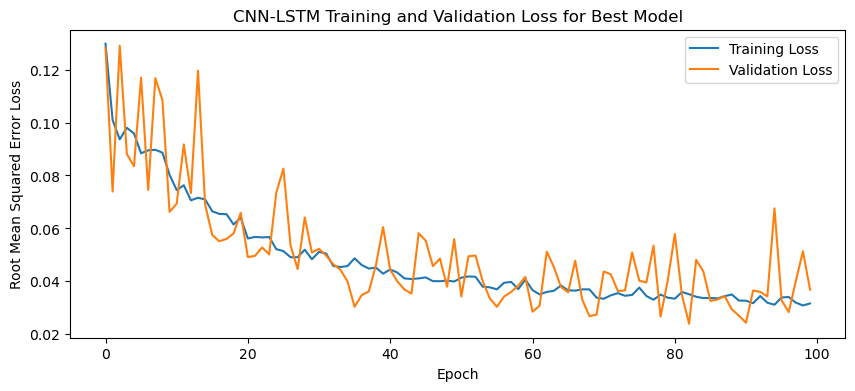

1/1 - 1s - loss: 0.0352 - 1s/epoch - 1s/step
Test Loss: 0.03519020602107048
1/1 [==============================] - 0s 35ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

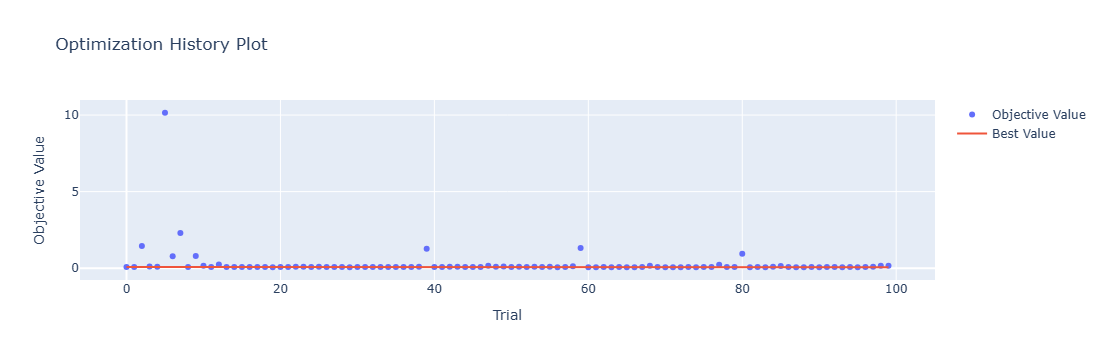

In [4]:
optuna.visualization.plot_optimization_history(study)

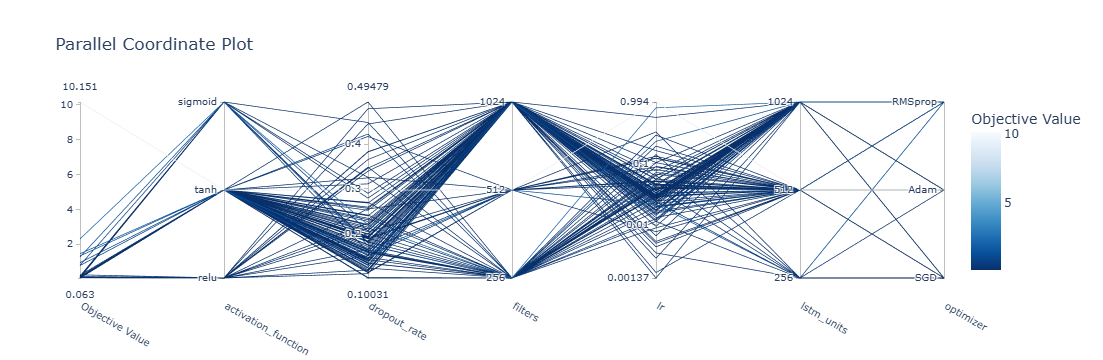

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

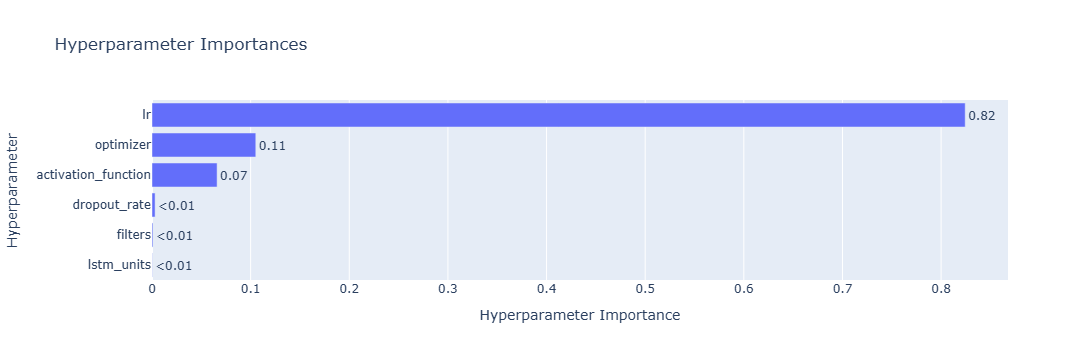

In [6]:
optuna.visualization.plot_param_importances(study)

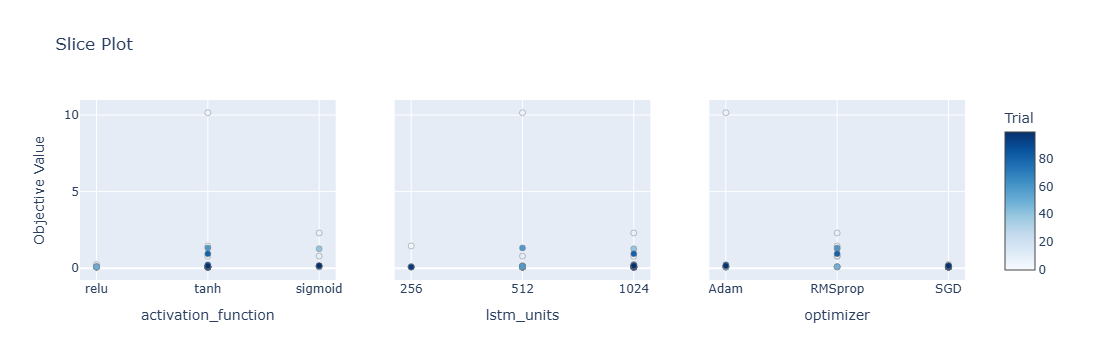

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

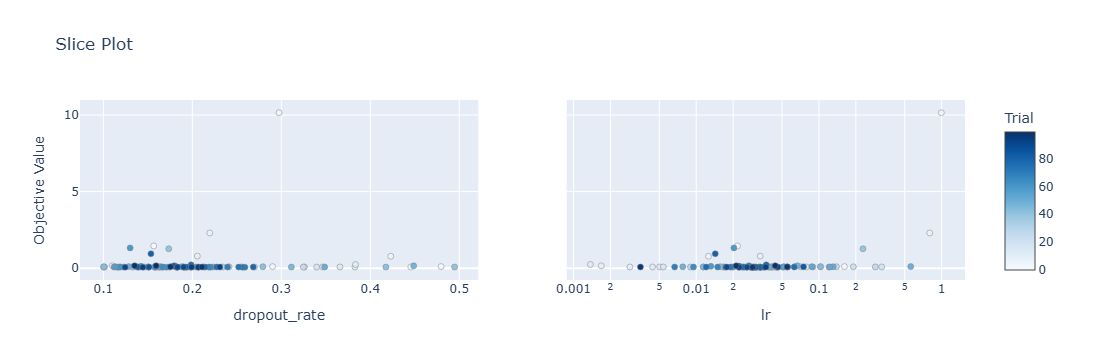

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 32s 198ms/step - loss: 0.1280 - accuracy: 0.8333 - mae: 0.1099 - rmse: 0.1280 - mape: 19.7052 - pearson: 0.7976 - val_loss: 0.0914 - val_accuracy: 1.0000 - val_mae: 0.0734 - val_rmse: 0.0914 - val_mape: 14.2875 - val_pearson: 0.9208
Epoch 2/100
84/84 [==============================] - 13s 154ms/step - loss: 0.0979 - accuracy: 0.8810 - mae: 0.0858 - rmse: 0.0979 - mape: 16.0617 - pearson: 0.8185 - val_loss: 0.0888 - val_accuracy: 1.0000 - val_mae: 0.0752 - val_rmse: 0.0888 - val_mape: 14.0773 - val_pearson: 0.9445
Epoch 3/100
84/84 [==============================] - 13s 155ms/step - loss: 0.1010 - accuracy: 0.8810 - mae: 0.0868 - rmse: 0.1010 - mape: 16.2592 - pearson: 0.8277 - val_loss: 0.1400 - val_accuracy: 1.0000 - val_mae: 0.1310 - val_rmse: 0.1400 - val_mape: 26.0614 - val_pearson: 0.9370
Epoch 4/100
84/84 [==============================] - 13s 157ms/step - loss: 0.1015 - accuracy: 0.8929 - mae: 0.0875 - rmse: 0.1015 - mape: 16.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 13s 153ms/step - loss: 0.0667 - accuracy: 0.9167 - mae: 0.0574 - rmse: 0.0667 - mape: 10.8199 - pearson: 0.8849 - val_loss: 0.0789 - val_accuracy: 1.0000 - val_mae: 0.0694 - val_rmse: 0.0789 - val_mape: 13.8894 - val_pearson: 0.9701
Epoch 14/100
84/84 [==============================] - 12s 148ms/step - loss: 0.0766 - accuracy: 0.9167 - mae: 0.0651 - rmse: 0.0766 - mape: 12.1382 - pearson: 0.8751 - val_loss: 0.0737 - val_accuracy: 1.0000 - val_mae: 0.0632 - val_rmse: 0.0737 - val_mape: 12.7461 - val_pearson: 0.9710
Epoch 15/100
84/84 [==============================] - 12s 142ms/step - loss: 0.0704 - accuracy: 0.8929 - mae: 0.0605 - rmse: 0.0704 - mape: 11.3814 - pearson: 0.8644 - val_loss: 0.0688 - val_accuracy: 1.0000 - val_mae: 0.0596 - val_rmse: 0.0688 - val_mape: 11.5510 - val_pearson: 0.9678
Epoch 16/100
84/84 [==============================] - 12s 139ms/step - loss: 0.0649 - accuracy: 0.9048 - mae: 0.0554 - rmse: 0.0649 - mape: 10.2570 - pe

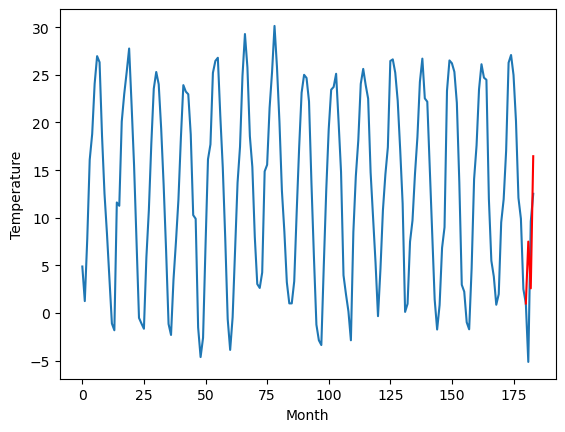

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.34		7.01		-1.33
11.77		9.98		-1.79
13.37		11.65		-1.72
[180, 181, 182, 183]
[14.25, 7.012798442840576, 9.976531639099122, 11.650383367538453]


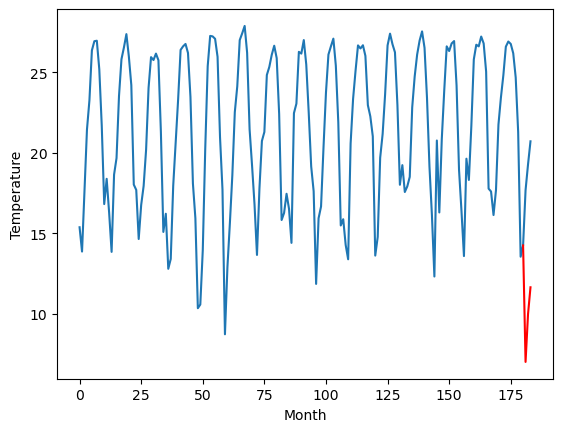

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		3.35		-0.94
2.37		2.88		0.51
11.70		10.84		-0.86
[180, 181, 182, 183]
[9.06, 3.34744478225708, 2.878982046842575, 10.840150812864303]


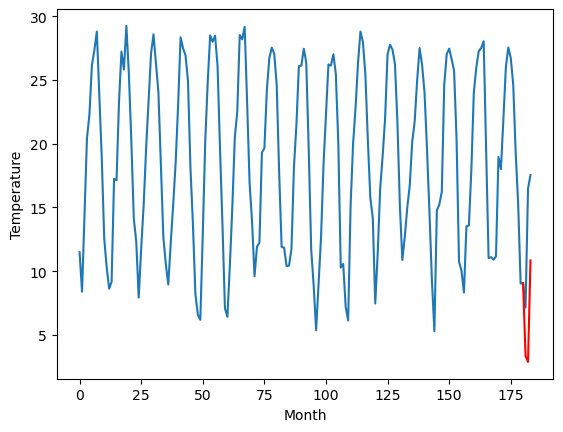

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.70		2.38		-0.32
-0.76		-0.64		0.12
10.20		10.14		-0.06
[180, 181, 182, 183]
[7.48, 2.3846467685699464, -0.6392921257019042, 10.141623134613038]


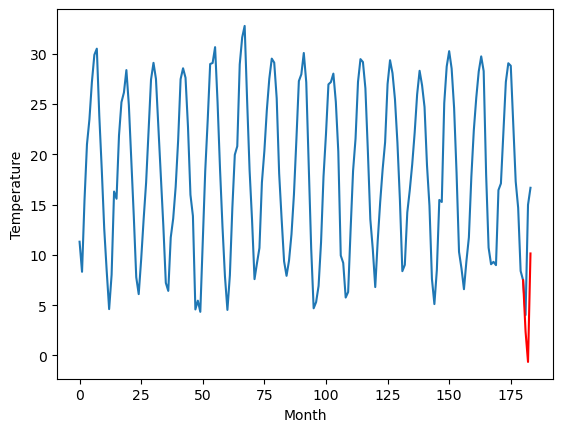

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		3.63		-0.66
0.40		0.58		0.18
11.32		11.31		-0.01
[180, 181, 182, 183]
[7.33, 3.63198842048645, 0.584162845611572, 11.307762279510499]


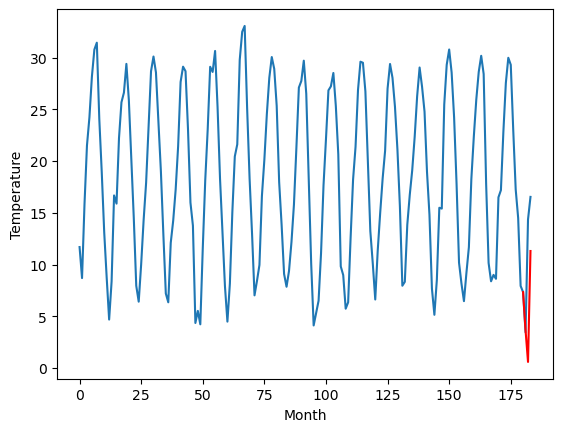

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.28		14.38		0.10
12.71		13.51		0.80
21.96		20.59		-1.37
[180, 181, 182, 183]
[6.59, 14.376154069900513, 13.51178026676178, 20.589544301033023]


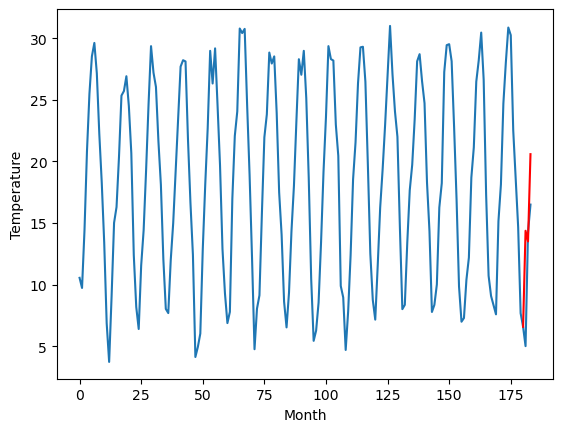

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.72		10.24		-1.48
12.39		11.39		-1.00
18.79		17.14		-1.65
[180, 181, 182, 183]
[6.04, 10.24125777721405, 11.385231366157532, 17.144763817787172]


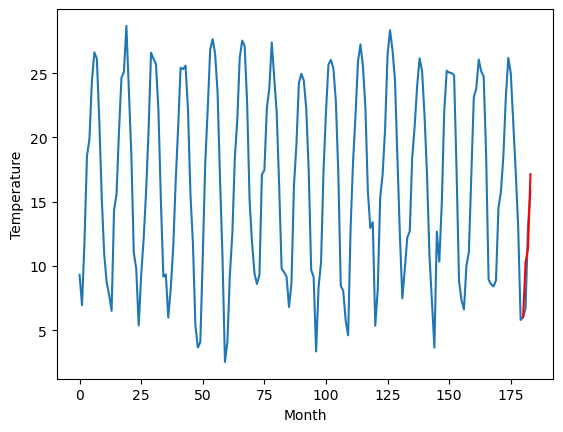

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.64		9.81		0.17
6.03		6.74		0.71
18.30		18.32		0.02
[180, 181, 182, 183]
[3.13, 9.80500036239624, 6.736517009735108, 18.318458614349368]


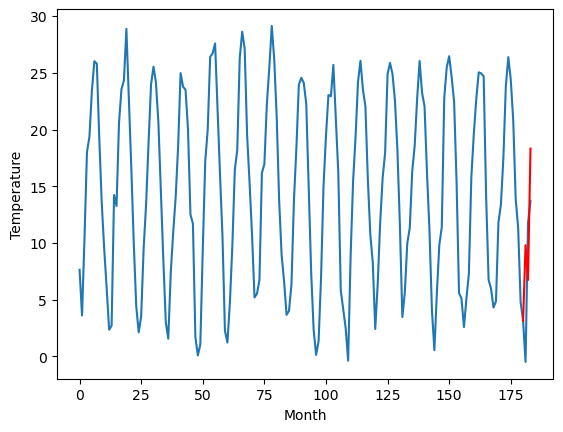

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.11		9.45		-0.66
6.75		6.70		-0.05
18.72		17.79		-0.93
[180, 181, 182, 183]
[-0.29, 9.452005567550659, 6.703475179672241, 17.787591161727903]


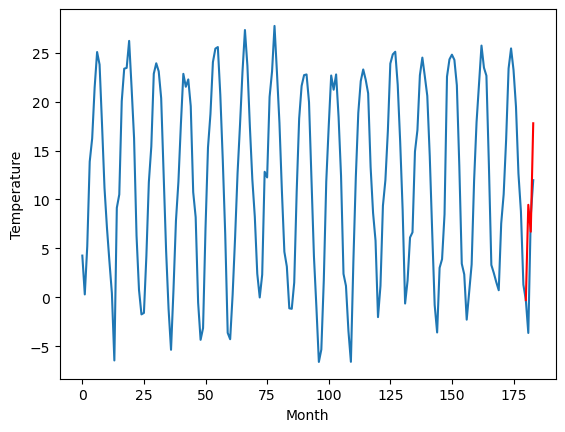

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		8.36		-0.17
4.09		4.01		-0.08
17.95		17.36		-0.59
[180, 181, 182, 183]
[-1.03, 8.361408052444459, 4.009012041091919, 17.35636311531067]


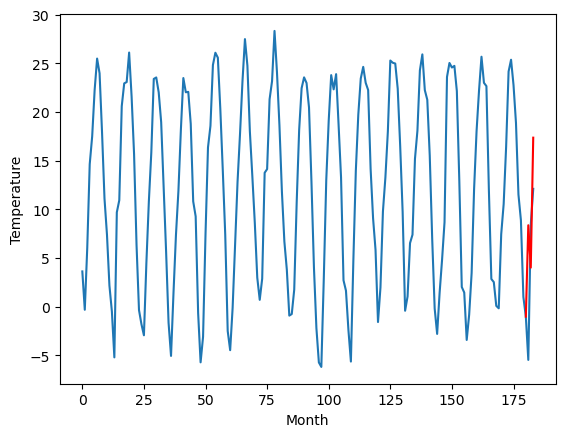

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.40		6.54		-0.86
5.16		4.80		-0.36
15.05		13.71		-1.34
[180, 181, 182, 183]
[-2.29, 6.537598199844361, 4.798943586349488, 13.711050100326538]


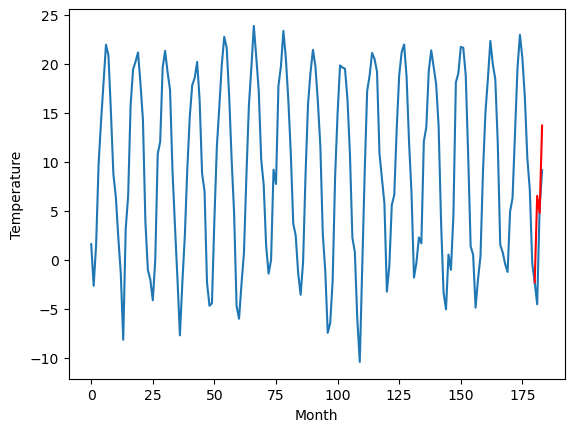

RangeIndex(start=1, stop=12, step=1)
[7.810000000000001, 8.339999999999998, 4.290000000000002, 2.7000000000000006, 4.289999999999999, 14.280000000000001, 11.719999999999999, 9.64, 10.11, 8.53, 7.4]
[7.505213565826416, 7.012798442840576, 3.34744478225708, 2.3846467685699464, 3.63198842048645, 14.376154069900513, 10.24125777721405, 9.80500036239624, 9.452005567550659, 8.361408052444459, 6.537598199844361]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.81   7.505214
1                 1    8.34   7.012798
2                 2    4.29   3.347445
3                 3    2.70   2.384647
4                 4    4.29   3.631988
5                 5   14.28  14.376154
6                 6   11.72  10.241258
7                 7    9.64   9.805000
8                 8   10.11   9.452006
9                 9    8.53   8.361408
10               10    7.40   6.537598


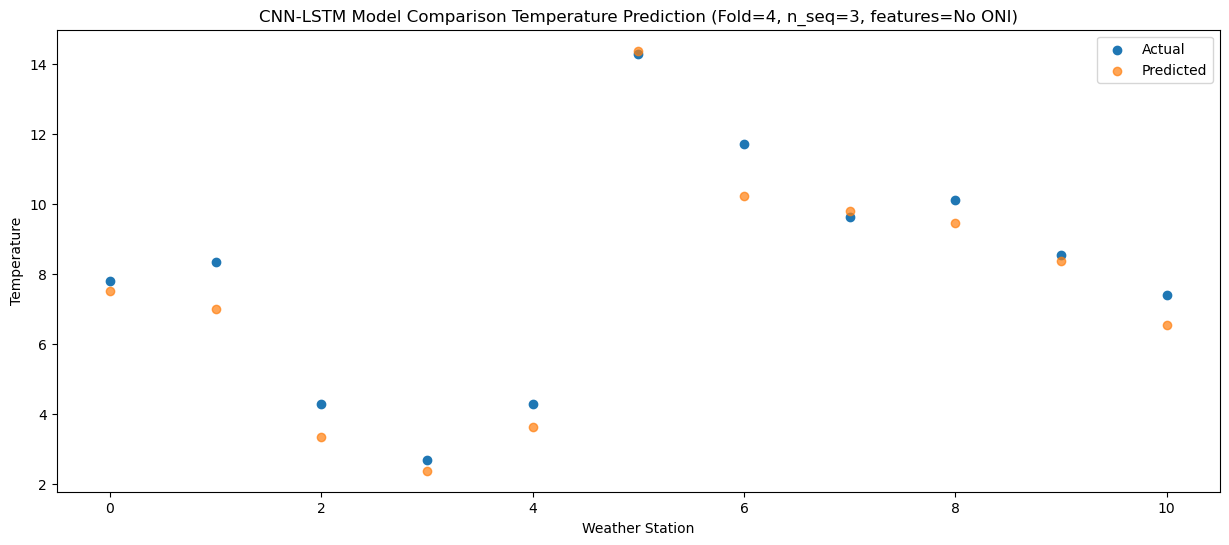

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    1.68   2.597293
1                 1   11.77   9.976532
2                 2    2.37   2.878982
3                 3   -0.76  -0.639292
4                 4    0.40   0.584163
5                 5   12.71  13.511780
6                 6   12.39  11.385231
7                 7    6.03   6.736517
8                 8    6.75   6.703475
9                 9    4.09   4.009012
10               10    5.16   4.798944


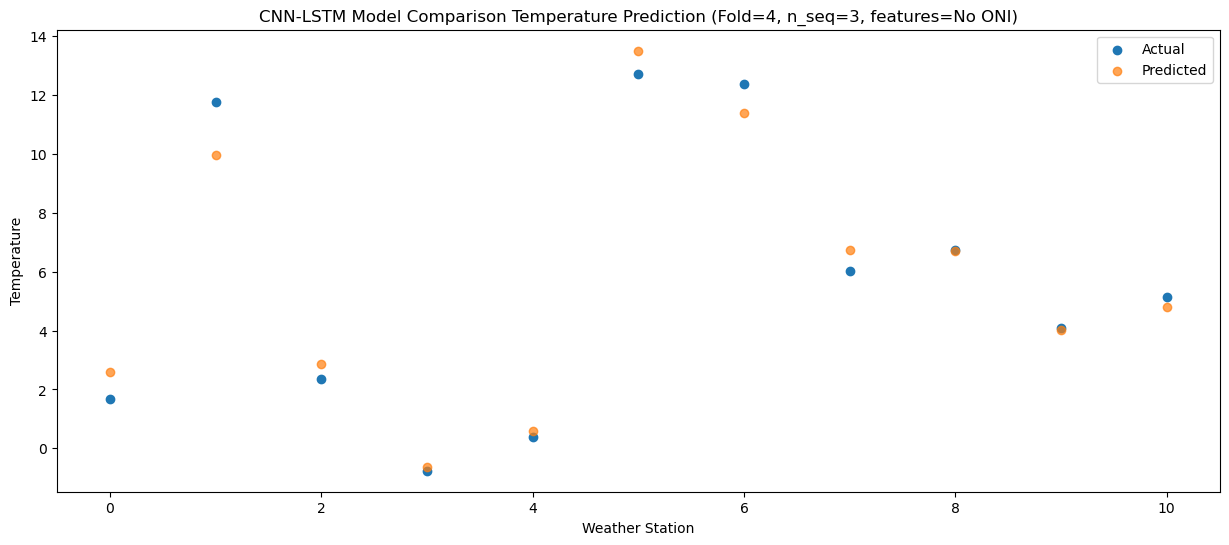

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   16.41  16.461531
1                 1   13.37  11.650383
2                 2   11.70  10.840151
3                 3   10.20  10.141623
4                 4   11.32  11.307762
5                 5   21.96  20.589544
6                 6   18.79  17.144764
7                 7   18.30  18.318459
8                 8   18.72  17.787591
9                 9   17.95  17.356363
10               10   15.05  13.711050


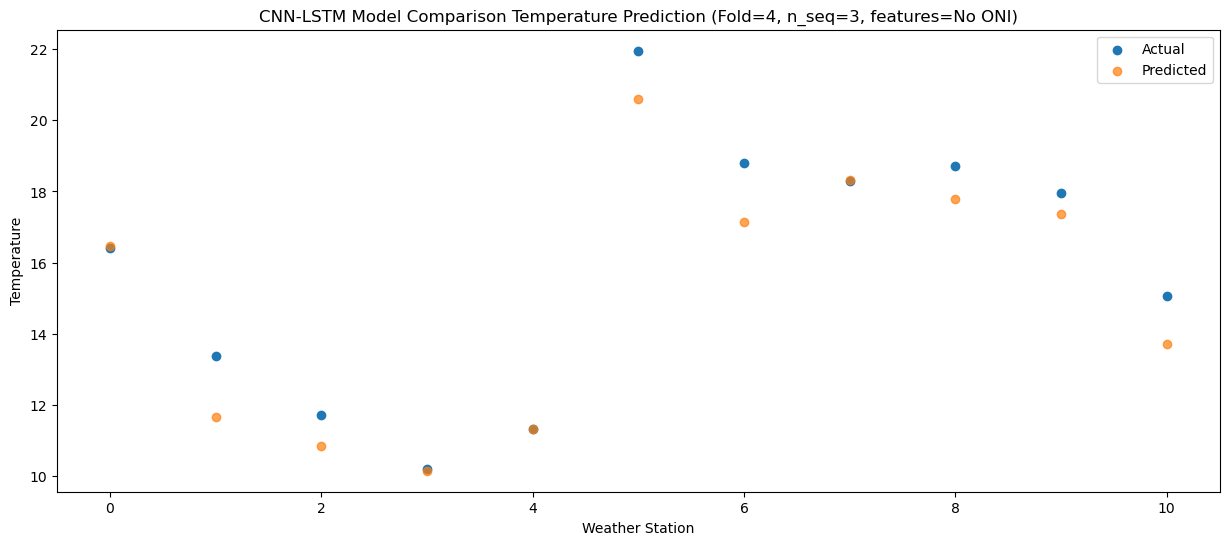

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 1024)           8392704   
                                                                 
 dropout_13 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_9 (LSTM)               (None, 1024)              8392704   
                                                      

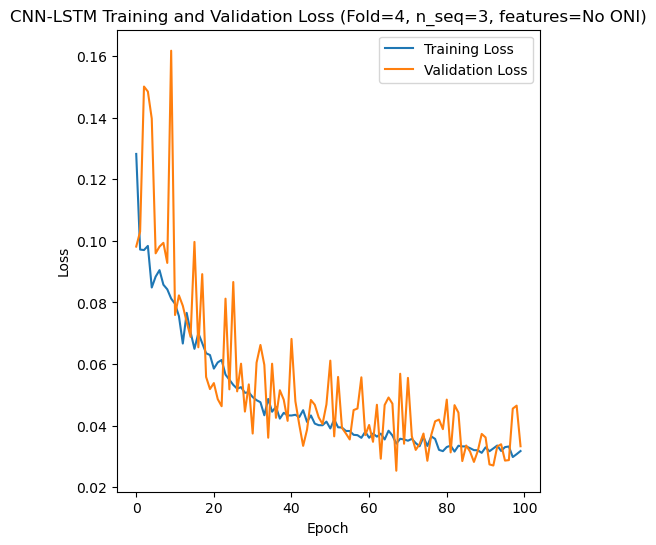

[[0.5758336387574695, 0.8266324032355801, 2.1501899892380187], [0.7743328323232642, 0.993115789493431, 0.6204180054084025], [0.8543575904352921, 1.7050254598997172, 2.1872995886320066], [0.4881002860928755, 2.0759458344168555, 1.0428333518940027], [0.780644375479769, 0.7778856547662104, 1.0136569469116345]]
[[0.44317000064660267, 0.6727992809834812, 1.9796391836011948], [0.5774196132204753, 0.8599960629777477, 0.5016843827475207], [0.678560915947891, 1.2606494201520795, 1.3479631761872126], [0.362197430621494, 1.8711531822518865, 0.857515656054019], [0.6342538959329777, 0.5932953599366271, 0.7818870034001087]]
[[0.049644939566736636, 0.09678863451028487, 0.12250294455561667], [0.06674225116875067, 0.10743485151753009, 0.030883972441455868], [0.08692917982842331, 0.1678793478154383, 0.10969236952274976], [0.09388546472947329, 0.6022140932828387, 0.13005825554242814], [0.09449665057898747, 0.17185349059554947, 0.04862497777099207]]
[[0.9469775730474586, 0.9377489596151585, 0.382547085037

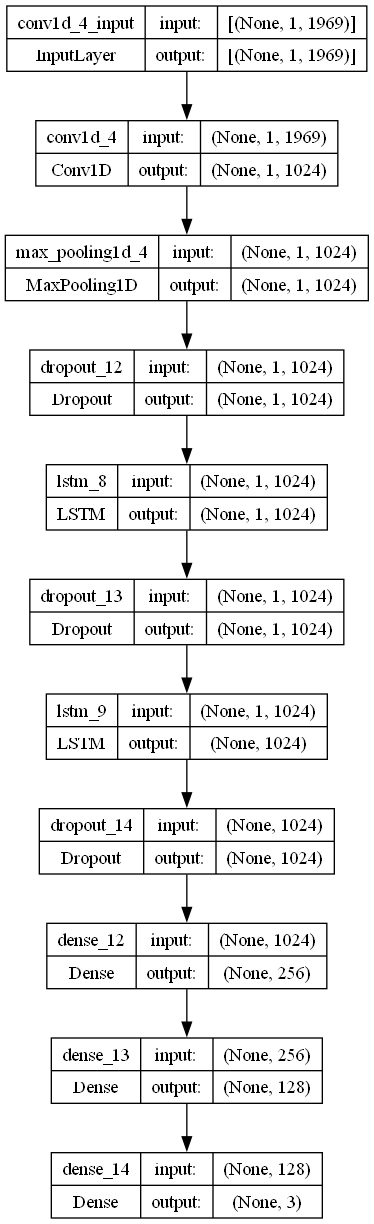

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 1024
    lr = 0.03538923105535606
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.19828711467502935

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with a CNN-LSTM model,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S3_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)